## Download data

In [12]:
import yfinance as yf

# Create a ticker object
msft = yf.Ticker("MSFT")

# Download full price history of stock
msft_hist = msft.history(period="max")

In [13]:
# Check the DataFrame returned by yfinance using 'head' method from 'pandas'
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062980,0.064609,0.062980,0.064067,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.064067,0.064610,0.061894,0.062437,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062437,0.062980,0.060809,0.061351,47894400,0.0,0.0


<AxesSubplot: xlabel='Date'>

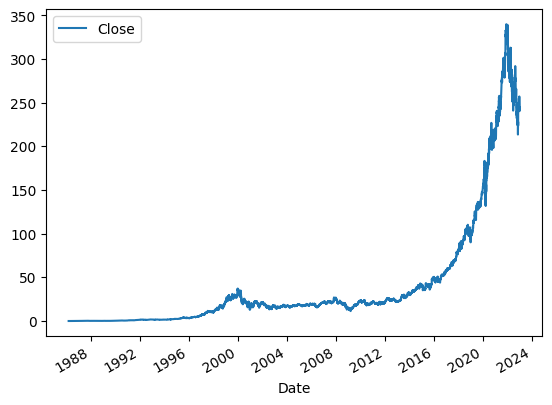

In [14]:
# Plot close price in y-axis vs. date (index) in x-axis
msft_hist.plot.line(y="Close", use_index=True)

## Prepare data for ML

In [15]:
# We will work with the closing price of the stock for predictions
data = msft_hist[["Close"]]
data = data.rename(columns = {"Close": "Actual_Close"})

Now we will use the __rolling__ method from *__pandas__* to compare the closing price between two consecutive days: if the closing price on day *i* is higher than the closing price in day *i-1*, then we will get 1 (from the *__lambda__* function), otherwise, we get zero. We will store these values on a new column in the __data__ DataFrame.

In [16]:
# Check whether stock price closed higher or lower than previous day
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Print DataFrame to check.
# Target = 1, means price close higher than previous day
# Target = 0, means price close lower than previous day
data.head(5)

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.060809,NaN
1986-03-14 00:00:00-05:00,0.062980,1.0
1986-03-17 00:00:00-05:00,0.064067,1.0
1986-03-18 00:00:00-05:00,0.062437,0.0
1986-03-19 00:00:00-05:00,0.061351,0.0


Now let's shift the historical data one day forward (you will se below why), i.e., the data from 3/13 will be put on 3/14, the data from 3/14 will be put on 3/15, and so on...

In [17]:
# Shift data 1 day forward
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062980,0.064609,0.062980,0.064067,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.064067,0.064610,0.061894,0.062437,6.776640e+07,0.0,0.0


Notice that the first row (3/13) is automatically filled with NaN's, so we need to omit this row later!

Now it is time to define our *__predictors__*, i.e., the variables that we will use to make predictions about the closing price on the next day. In this case, we will use the following variables from the previous day:
- Close price
- High price
- Low price
- Open price
- Volume

In [18]:
# Define predictors (variables to be used to make predictions)
predictors = ["Close", "High", "Low", "Open", "Volume"]

Now let's join our __data__ DataFrame with the predictors in the shifted data DataFrame (i.e., __msft_prev__). Remember to omit the first row (with NaNs).

In [19]:
# Join predictors in shifted data with the DataFrame that includes our target
# Do not include the first row in the shifted data, since it is NaN
data = data.join(msft_prev[predictors]).iloc[1:]
data.head(5)

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062980,1.0,0.060809,0.063524,0.055380,0.055380,1.031789e+09
1986-03-17 00:00:00-05:00,0.064067,1.0,0.062980,0.064067,0.060809,0.060809,3.081600e+08
1986-03-18 00:00:00-05:00,0.062437,0.0,0.064067,0.064609,0.062980,0.062980,1.331712e+08
1986-03-19 00:00:00-05:00,0.061351,0.0,0.062437,0.064610,0.061894,0.064067,6.776640e+07
1986-03-20 00:00:00-05:00,0.059723,0.0,0.061351,0.062980,0.060809,0.062437,4.789440e+07


Notice the structure of this new DataFrame: We have the __Actual_close__ on 3/14, and the __Target__ is 1, which means that 3/14 closed higher than 3/13.

The rest of the columns contain information from 3/13. And here's why we shifted the data a couple of lines before: In a real-world scenario, we will use the information from 3/13 (i.e., known information) to predict the closing price on 3/14, which is *unknown*. With this structure we make sure that we are not using data from the future to make predictions (i.e., avoid *leaking*)

## Training a ML model

For this case we will use a *__classifier__* instead of *__regression__* since our output (i.e., __Target__) is a binary variable: either 1 or 0. We will use a *__Random Forest__* classifier which tends to be fairly robust to overfitting (if we set the right parameters), and it is able to handle nonlinear relations between the data

In [21]:
from sklearn.ensemble import RandomForestClassifier

Let's initialize the model with the following parameters:
- n_estimators = 100 -> Number of individual decision trees to run. Result will be the average of all the results
- min_samples_split = 200 -> Try to avoid overfitting
- random_state = 1 -> allow me to replicate results (like seed for rng)

In [22]:
# Initialize model
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

It is recommended to do *__backtesting__* in order to check the validity of a model. But first we will train this model to check how it works. *__BE AWARE__* The following steps are done only to check how it works, but this is not the recommended way to proceed!!!

In [23]:
# Divide data into 'training set' and 'testing set' 
train = data.iloc[:-100]
test = data.iloc[-100:]

# Fit the model to 'training set'. Use 'predictors' to predict 'Target'
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [27]:
import pandas as pd
from sklearn.metrics import precision_score

# Time to make predictions
preds = model.predict(test[predictors])

# model.predict will return a Numpy array with the predictions. Let's convert it to
# pandas series
preds = pd.Series(preds, index=test.index)
preds

Date
2022-08-02 00:00:00-04:00    0.0
2022-08-03 00:00:00-04:00    1.0
2022-08-04 00:00:00-04:00    1.0
2022-08-05 00:00:00-04:00    0.0
2022-08-08 00:00:00-04:00    0.0
                            ... 
2022-12-15 00:00:00-05:00    1.0
2022-12-16 00:00:00-05:00    1.0
2022-12-19 00:00:00-05:00    1.0
2022-12-20 00:00:00-05:00    1.0
2022-12-21 00:00:00-05:00    0.0
Length: 100, dtype: float64

In [28]:
# Calculate 'precision_score'
precision_score(test["Target"], preds)

0.5

In [29]:
# Concatenate data sets
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
combined

,Target,Predictions
Date,,
2022-08-02 00:00:00-04:00,0.0,0.0
2022-08-03 00:00:00-04:00,1.0,1.0
2022-08-04 00:00:00-04:00,1.0,1.0
2022-08-05 00:00:00-04:00,0.0,0.0
2022-08-08 00:00:00-04:00,0.0,0.0
...,...,...
2022-12-15 00:00:00-05:00,0.0,1.0
2022-12-16 00:00:00-05:00,0.0,1.0
2022-12-19 00:00:00-05:00,0.0,1.0


<AxesSubplot: xlabel='Date'>

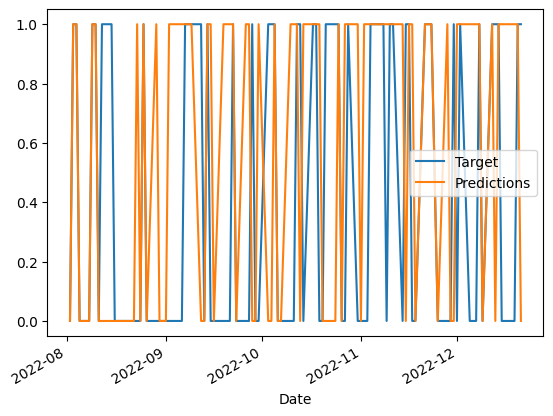

In [30]:
# Let's plot results
combined.plot()

## Creating a backtesting engine

In [36]:
# Let's use the first 1000 rows of data to start backtesting
# Train model every 750 rows
start = 1000
step = 750   # Step higher so it runs fast. In real-world, use smaller (for instance = 100)

# Initialize list for predictions
predictions = []

for i in range(start, data.shape[0], step):
    # Create training and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit model to training set
    model.fit(train[predictors], train["Target"])

    # Compute probability of predictions: Let's define a higher threshold = 0.6,
    # so we maximize true positives. Therefore, if:
    # - probability <= 0.6 means 'Target' is zero
    # - probability > 0.6 means 'Target' is 1
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > 0.6] = 1
    preds[preds <= 0.6] = 0

    # Concatenate results
    combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

    # Append results to final list
    predictions.append(combined)

# Concatenate predictions, so we have a nice DataFrame at the end
predictions = pd.concat(predictions)

In [33]:
# Check value counts
predictions["Predictions"].value_counts()

0.0    7554
1.0     716
Name: Predictions, dtype: int64

In [35]:
# Check precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.5069832402234636